In [522]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import operator
import json
import csv

%matplotlib inline

In [523]:
datapath = "../data_preprocessed_01/current.csv"
data = pd.read_csv(datapath)

In [524]:
# col_list = ['over_and_ball', 'batsman',
#             'non_striker', 'bowler', 'runs_off_bat', 'extras', 'wides', 'no_balls', 'byes', 'leg_byes', 'penalty', 'kind_of_wicket', 'dismissed_player', 'valid_ball', 'date', 'runs_scored', 'wickets_fallen', 'balls_bowled',]
# data = data.drop(col_list, axis=1)

In [525]:
# Increment over by 1
data['overs'] = data['overs'] + 1

In [526]:
col_batting_team = data.groupby(['match_id', 'innings', 'fielding_team'])['batting_team_name']
col_batting_team = pd.DataFrame(col_batting_team)
col_batting_team['list_col'] = col_batting_team[0].apply(lambda x: list(x))
col_batting_team = col_batting_team.drop(columns=[0, 1])
col_batting_team['match_id'] = col_batting_team['list_col'].apply(lambda x: x[0])
col_batting_team['inning'] = col_batting_team['list_col'].apply(lambda x: x[1])
col_batting_team['batting_team'] = col_batting_team['list_col'].apply(lambda x: x[2])
col_batting_team = col_batting_team.drop(columns=['list_col'])

In [527]:
col_fielding_team = data.groupby(['match_id', 'innings', 'batting_team_name'])['fielding_team']
col_fielding_team = pd.DataFrame(col_fielding_team)
col_fielding_team['list_col'] = col_fielding_team[0].apply(lambda x: list(x))
col_fielding_team = col_fielding_team.drop(columns=[0, 1])
col_fielding_team['match_id'] = col_fielding_team['list_col'].apply(lambda x: x[0])
col_fielding_team['inning'] = col_fielding_team['list_col'].apply(lambda x: x[1])
col_fielding_team['fielding_team'] = col_fielding_team['list_col'].apply(lambda x: x[2])
col_fielding_team = col_fielding_team.drop(columns=['list_col'])

In [528]:
col_winner = data.groupby(['match_id', 'innings', 'batting_team_name','fielding_team','match_winner'])['match_winner']
col_winner = pd.DataFrame(col_winner)
col_winner['list_col'] = col_winner[0].apply(lambda x: list(x))
col_winner = col_winner.drop(columns=[0, 1])
col_winner['match_id'] = col_winner['list_col'].apply(lambda x: x[0])
col_winner['inning'] = col_winner['list_col'].apply(lambda x: x[1])
col_winner['winner'] = col_winner['list_col'].apply(lambda x: x[-1])
col_winner = col_winner.drop(columns=['list_col'])

In [529]:
wickets_in_over = data.groupby(['match_id', 'innings','overs'])['wicket_ball'].sum().unstack(fill_value=0)
wickets_in_over = pd.DataFrame(wickets_in_over)
wickets_in_over = wickets_in_over.to_numpy()
wickets_in_over = wickets_in_over.tolist()

In [530]:
match_ids = data.groupby(['match_id'])
match_ids = pd.DataFrame(match_ids)
match_ids = match_ids.drop(columns=[1], axis=1)

match_ids_list = []
for ele in match_ids[0]:
    id = list(ele)
    match_ids_list.append(id)

match_ids_list = np.array(match_ids_list)
match_ids_list = match_ids_list.reshape(-1)
list_match_ids = match_ids_list.tolist()

counts = Counter(list_match_ids)
col_match_ids = []
for number, count in counts.items():
    col_match_ids.extend([number] * 100)

In [531]:
runs_in_over = data.groupby(['match_id', 'innings', 'overs'])['runs_on_this_ball'].sum().unstack(fill_value=0)
runs_in_over = runs_in_over.to_numpy()
runs_in_over = runs_in_over.tolist()

In [532]:
wickets_in_hands = data.groupby(['match_id', 'innings', 'overs'])['wickets_in_hand'].max().unstack(fill_value=0)
wickets_in_hands = wickets_in_hands.to_numpy()
wickets_in_hands = wickets_in_hands.tolist()

In [533]:
col_wickets_in_hands = []
col_runs_scored_in_over = []
col_wickets_in_over = []

for i in range(len(wickets_in_hands)):
    for j in range(len(wickets_in_hands[0])):
        col_runs_scored_in_over.append(runs_in_over[i][j])
        col_wickets_in_hands.append(wickets_in_hands[i][j])
        col_wickets_in_over.append(wickets_in_over[i][j])

In [534]:
col_innings = np.empty(235800)

for i in range(0, 235800, 100):
    col_innings[i:i+50] = 1
    col_innings[i+50:i+100] = 2

In [535]:
array = np.arange(1, 51)
col_overs = np.tile(array, 235800 // 50)[:235800]

In [536]:
input_file_path = '../data_preprocessed_01/all_info_csv.csv'


# Open the CSV file for reading
with open(input_file_path, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.DictReader(csv_file)

    # Extract the header from the original CSV file
    header = csv_reader.fieldnames
    print(header)

    # Create a list to store the modified rows
    modified_rows = []

    # Process each row
    for row in csv_reader:
        # Assuming 'json_data' is the column containing JSON data in each row
        json_data = json.loads(row['info_dict'])

        # Extract the fields you want from the JSON data
        balls_per_over = json_data.get('balls_per_over', [''])
        team = json_data.get('team', [''])
        gender = json_data.get('gender', [''])
        toss_winner = json_data.get('toss_winner', [''])
        toss_decision = json_data.get('toss_decision', [''])
        winner = json_data.get('winner', [''])
        # Add more fields as needed

        # Update the row with the new columns
        row.update({
            'balls_per_over': ', '.join(balls_per_over),
            'team': ', '.join(team),
            'gender': ', '.join(gender),
            'toss_winner': ', '.join(toss_winner),
            'toss_decision': ', '.join(toss_decision),
            'winner': ', '.join(winner)
            # Add more columns as needed
        })

        # Append the modified row to the list
        modified_rows.append(row)
        
modified_rows = pd.DataFrame(modified_rows)
col = ['info_dict', 'balls_per_over', 'gender']
modified_rows = modified_rows.drop(col, axis=1)

modified_rows['teams'] = modified_rows['team'].apply(lambda x: list(x.split(',')))
modified_rows['team1'] = modified_rows['teams'].apply(lambda x: x[0])
modified_rows['team2'] = modified_rows['teams'].apply(lambda x: x[1])

col = ['team', 'teams', 'winner']
modified_rows = modified_rows.drop(col, axis=1)

modified_rows = pd.DataFrame(modified_rows)
modified_rows['match_id'] = modified_rows['match_id'].apply(lambda x: np.int64(x))

['match_id', 'info_dict']


In [537]:
updated_data = pd.read_csv('../data_preprocessed_01/updated_innings1.csv')
temp1 = updated_data.groupby(['match_id', 'innings', 'overs'])[
    'wrl'].mean().unstack(fill_value=0)
temp1 = temp1.to_numpy()
temp1 = temp1.tolist()

col_wrl = []
for i in range(len(temp1)):
    for j in range(len(temp1[0])):
        col_wrl.append(temp1[i][j])

updated_data2 = pd.read_csv('../data_preprocessed_01/updated_innings2.csv')
temp2 = updated_data2.groupby(['match_id', 'innings', 'overs'])[
    'wrl'].mean().unstack(fill_value=0)
temp2 = temp2.to_numpy()
temp2 = temp2.tolist()
col_wrl2 = []
for i in range(len(temp2)):
    for j in range(len(temp2[0])):
        col_wrl2.append(temp2[i][j])


size = 235800
wrl = np.zeros(size)
for index, ele in enumerate(col_wrl):
    wrl[2*index] = ele
for index, ele in enumerate(col_wrl2):
    wrl[2*index+1] = ele

In [538]:
temp1 = updated_data.groupby(['match_id', 'innings'])['fd'].min()
temp2 = updated_data2.groupby(['match_id', 'innings'])['fd'].min()

temp1 = temp1.to_numpy()
temp1 = temp1.tolist()

temp2 = temp2.to_numpy()
temp2 = temp2.tolist()

col_fd = []
for i in range(len(temp1)):
    col_fd.append(temp1[i])

col_fd2 = []
for i in range(len(temp2)):
    col_fd.append(temp2[i])

size = 235800
fd = np.zeros(size)
for index, ele in enumerate(col_fd):
    fd[2*index] = ele
for index, ele in enumerate(col_fd2):
    fd[2*index+1] = ele



In [539]:
column_names = ['match_id', 'team1', 'team2', 'toss_winner', 'toss_decision', 'batting_team', 'fielding_team', 'inning', 'over', 'runs_scored_in_over', 'wickets_in_hand', 'player_dismissed_in_over', 'runs_scored', 'wickets_fallen', 'target_score', 'runs_remaining', 'run_rate', 'required_run_rate', 'runrate_diff',  'winner', 'is_batting_team','wrl','fd','target']

In [540]:
df = pd.DataFrame(columns=column_names)
df['match_id'] = col_match_ids
df['inning'] = col_innings
df['over'] = col_overs
df['runs_scored_in_over'] = col_runs_scored_in_over
df['wickets_in_hands'] = col_wickets_in_hands
df['player_dismissed_in_over'] = col_wickets_in_over
df['wrl'] = wrl
df['fd'] = fd

In [541]:
df.head()

,match_id,team1,team2,toss_winner,toss_decision,batting_team,fielding_team,inning,over,runs_scored_in_over,...,runs_remaining,run_rate,required_run_rate,runrate_diff,winner,is_batting_team,wrl,fd,target,wickets_in_hands
0,64814,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,10
1,64814,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,7,...,NaN,NaN,NaN,NaN,NaN,NaN,0.809133,0.000000,NaN,10
2,64814,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-29.986872,NaN,10
3,64814,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,1.200514,0.000000,NaN,9
4,64814,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.393543,-53.853424,NaN,9


In [542]:
df['runs_scored'] = df.groupby(['match_id', 'inning'])['runs_scored_in_over'].cumsum()
df['wickets_fallen'] = df.groupby(['match_id', 'inning'])['player_dismissed_in_over'].cumsum()


In [543]:
temp_df = df.groupby(['match_id', 'inning'])['runs_scored'].sum().reset_index()
temp_df = temp_df.loc[temp_df['inning'] == 1, :]
temp_df['inning'] = 2
temp_df.columns = ['match_id', 'inning', 'target_score_']
df = df.merge(temp_df, how='left', on=['match_id', 'inning'])
df['target_score_'].fillna(-1, inplace=True)
df['target_score'] = df['target_score_']
df.drop(columns=['target_score_'],axis=1)


,match_id,team1,team2,toss_winner,toss_decision,batting_team,fielding_team,inning,over,runs_scored_in_over,...,runs_remaining,run_rate,required_run_rate,runrate_diff,winner,is_batting_team,wrl,fd,target,wickets_in_hands
0,64814,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,10
1,64814,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,7,...,NaN,NaN,NaN,NaN,NaN,NaN,0.809133,0.000000,NaN,10
2,64814,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-29.986872,NaN,10
3,64814,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,1.200514,0.000000,NaN,9
4,64814,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.393543,-53.853424,NaN,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235795,1395702,NaN,NaN,NaN,NaN,NaN,NaN,2.0,46,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0
235796,1395702,NaN,NaN,NaN,NaN,NaN,NaN,2.0,47,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0
235797,1395702,NaN,NaN,NaN,NaN,NaN,NaN,2.0,48,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0
235798,1395702,NaN,NaN,NaN,NaN,NaN,NaN,2.0,49,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0


In [544]:
def get_remaining_target(row):
    if row['target_score'] == -1.:
        return -1
    else:
        return row['target_score'] - row['runs_scored']

df['remaining_target'] = df.apply(lambda row: get_remaining_target(row), axis=1)

In [545]:
df['run_rate'] = df['runs_scored'] / df['over']

In [546]:
def get_required_rr(row):
    if row['remaining_target'] == -1:
        return -1.
    elif row['over'] == 50:
        return row['remaining_target']
    else:
        return row['remaining_target'] / (50-row['over'])


df['required_run_rate'] = df.apply(lambda row: get_required_rr(row), axis=1)

In [547]:
def get_rr_diff(row):
    if row['inning'] == 1:
        return -1
    else:
        return row['run_rate'] - row['required_run_rate']


df['runrate_diff'] = df.apply(lambda row: get_rr_diff(row), axis=1)

In [548]:
df = df.merge(col_batting_team, on=['match_id', 'inning'], how='left')
df = df.merge(col_fielding_team, on=['match_id', 'inning'], how='inner')
df = df.merge(col_winner, on=['match_id','inning'],how='inner')

df['batting_team_x'] = df['batting_team_y']
df['fielding_team_x'] = df['fielding_team_y']
df['winner_x'] = df['winner_y']
df = df.drop(columns=['batting_team_y', 'fielding_team_y', 'winner_y'], axis=1)
df = df.rename(columns={'batting_team_x': 'fielding_team','fielding_team_x': 'batting_team', 'winner_x': 'winner'})

In [549]:
df = df.merge(modified_rows, on=['match_id'], how='inner')

df['team1_x'] = df['team1_y']
df['team2_x'] = df['team2_y']
df['toss_winner_x'] = df['toss_winner_y']
df['toss_decision_x'] = df['toss_decision_y']
df = df.drop(columns=['team1_y', 'team2_y',
             'toss_winner_y', 'toss_decision_y'], axis=1)
df = df.rename(columns={'team1_x': 'team1',
               'team2_x': 'team2', 'toss_winner_x': 'toss_winner','toss_decision_x':'toss_decision'})


In [550]:
df['is_batting_team'] = (df['team1'] == df['batting_team']).astype('int')


In [551]:
col_head_2_head = data.groupby(['match_id', 'innings', 'batting_team_name', 'fielding_team'])['head_2_head']
col_head_2_head = pd.DataFrame(col_head_2_head)
col_head_2_head['match_id'] = col_head_2_head[0].apply(lambda x: x[0])
col_head_2_head['inning'] = col_head_2_head[0].apply(lambda x: x[1])
col_head_2_head['h2h'] = col_head_2_head[1].apply(lambda x: list(x))
col_head_2_head['head_2_head'] = col_head_2_head['h2h'].apply(lambda x: x[0])
col_head_2_head = col_head_2_head.drop(columns=[0, 1, 'h2h'])

df = df.merge(col_head_2_head,on=['match_id','inning'],how='inner')

In [552]:
col_last_5_m_b = data.groupby(
    ['match_id', 'innings', 'batting_team_name'])['Last_5_matches_batting_team']

col_last_5_m_b = pd.DataFrame(col_last_5_m_b)

col_last_5_m_b['match_id'] = col_last_5_m_b[0].apply(lambda x: x[0])
col_last_5_m_b['inning'] = col_last_5_m_b[0].apply(lambda x: x[1])
col_last_5_m_b['last_5_matches_batting_team_'] = col_last_5_m_b[1].apply(
    lambda x: list(x))
col_last_5_m_b['last_5_matches_batting_team'] = col_last_5_m_b['last_5_matches_batting_team_'].apply(
    lambda x: x[0])
col_last_5_m_b = col_last_5_m_b.drop(
    columns=[0, 1, 'last_5_matches_batting_team_'], axis=1)
df = df.merge(col_last_5_m_b, on=['match_id', 'inning'], how='inner')

In [553]:
col_last_5_m_f = data.groupby(
    ['match_id', 'innings', 'fielding_team'])['Last_5_matches_fielding_team']

col_last_5_m_f = pd.DataFrame(col_last_5_m_f)
# col_last_5_m_f

col_last_5_m_f['match_id'] = col_last_5_m_f[0].apply(lambda x: x[0])
col_last_5_m_f['inning'] = col_last_5_m_f[0].apply(lambda x: x[1])
col_last_5_m_f['last_5_matches_fielding_team_'] = col_last_5_m_f[1].apply(
    lambda x: list(x))
col_last_5_m_f['last_5_matches_fielding_team'] = col_last_5_m_f['last_5_matches_fielding_team_'].apply(
    lambda x: x[0])
col_last_5_m_f = col_last_5_m_f.drop(
    columns=[0, 1, 'last_5_matches_fielding_team_'], axis=1)
df = df.merge(col_last_5_m_f, on=['match_id', 'inning'], how='inner')

In [554]:
df['target'] = (df['team1'] == df['winner']).astype('int')

In [555]:
df.to_csv('../data_preprocessed_01/final_output.csv')
df.head()

,match_id,team1,team2,toss_winner,toss_decision,fielding_team,batting_team,inning,over,runs_scored_in_over,...,is_batting_team,wrl,fd,target,wickets_in_hands,target_score_,remaining_target,head_2_head,last_5_matches_batting_team,last_5_matches_fielding_team
0,64814,New Zealand,India,India,field,India,New Zealand,1.0,1,2,...,1,0.000000,0.000000,1,10,-1.0,-1.0,0,0,0
1,64814,New Zealand,India,India,field,India,New Zealand,1.0,2,7,...,1,0.809133,0.000000,1,10,-1.0,-1.0,0,0,0
2,64814,New Zealand,India,India,field,India,New Zealand,1.0,3,1,...,1,0.000000,-29.986872,1,10,-1.0,-1.0,0,0,0
3,64814,New Zealand,India,India,field,India,New Zealand,1.0,4,2,...,1,1.200514,0.000000,1,9,-1.0,-1.0,0,0,0
4,64814,New Zealand,India,India,field,India,New Zealand,1.0,5,1,...,1,0.393543,-53.853424,1,9,-1.0,-1.0,0,0,0


In [556]:
x_cols = ['inning', 'over', 'runs_scored_in_over', 'player_dismissed_in_over', 'wickets_fallen', 'runs_scored', 'target_score',
          'remaining_target', 'run_rate', 'required_run_rate', 'runrate_diff', 'is_batting_team','head_2_head','last_5_matches_batting_team','last_5_matches_fielding_team','wrl','fd']

# let us take all the matches but for the final as development sample and final as val sample #

# India vs Australia (ICC ODI worldcup league match) 1384396
# Afghanistan vs Australia (ICC ODI world cup league match) 1384430
val_df_1 = df.loc[df.match_id == 1384430, :]
dev_df_1 = df.loc[df.match_id != 1384430, :]

val_df_1 = val_df_1.loc[val_df_1.inning == 1, :]
dev_df_1 = dev_df_1.loc[dev_df_1.inning == 1, :]

# create the input and target variables #
dev_X_1 = np.array(dev_df_1[x_cols[:]])
dev_y_1 = np.array(dev_df_1['target'])
val_X_1 = np.array(val_df_1[x_cols[:]])[:, :]
val_y_1 = np.array(val_df_1['target'])[:]
print(dev_X_1.shape, dev_y_1.shape)
print(val_X_1.shape, val_y_1.shape)

(115000, 17) (115000,)
(50, 17) (50,)


In [557]:
val_df_2 = df.loc[df.match_id == 1384430, :]
dev_df_2 = df.loc[df.match_id != 1384430, :]

val_df_2 = val_df_2.loc[val_df_2.inning == 2, :]
dev_df_2 = dev_df_2.loc[dev_df_2.inning == 2, :]
# create the input and target variables #
dev_X_2 = np.array(dev_df_2[x_cols[:]])
dev_y_2 = np.array(dev_df_2['target'])
val_X_2 = np.array(val_df_2[x_cols[:]])[:, :]
val_y_2 = np.array(val_df_2['target'])[:]
print(dev_X_2.shape, dev_y_2.shape)
print(val_X_2.shape, val_y_2.shape)

(115000, 17) (115000,)
(50, 17) (50,)


In [558]:
# define the function to create the model #
def runXGB(train_X, train_y, seed_val=0):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.05
    param['max_depth'] = 8
    param['silent'] = 1
    param['eval_metric'] = "auc"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = 100

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    model = xgb.train(plst, xgtrain, num_rounds)
    dev_test = xgb.DMatrix(train_X)
    dev_pred = model.predict(dev_test)
    return model, dev_pred

In [559]:
# let us build the model and get predcition for the final match #
model_1,dev_pred_1 = runXGB(dev_X_1, dev_y_1)
xgtest_1 = xgb.DMatrix(val_X_1)
preds_1 = model_1.predict(xgtest_1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [01:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


In [560]:
binary_pred_1 = [0.0 if prob < 0.5 else 1.0 for prob in dev_pred_1]


In [561]:
# let us build the model and get predcition for the final match #
model_2,dev_pred_2 = runXGB(dev_X_2, dev_y_2)
xgtest_2 = xgb.DMatrix(val_X_2)
preds_2 = model_2.predict(xgtest_2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [01:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


In [562]:
binary_pred_2 = [0.0 if prob < 0.5 else 1.0 for prob in dev_pred_2]


In [563]:
correct_predictions = sum(a == p for a, p in zip(dev_y_1, binary_pred_1))
total_predictions = len(dev_y_1)
accuracy_1 = correct_predictions / total_predictions

print(f"Accuracy of Innings 1: {accuracy_1 * 100:.2f}%")

Accuracy of Innings 1: 79.19%


In [564]:
correct_predictions = sum(a == p for a, p in zip(dev_y_2, binary_pred_2))
total_predictions = len(dev_y_2)
accuracy_2 = correct_predictions / total_predictions

print(f"Accuracy of Innings 2: {accuracy_2 * 100:.2f}%")

Accuracy of Innings 2: 92.78%


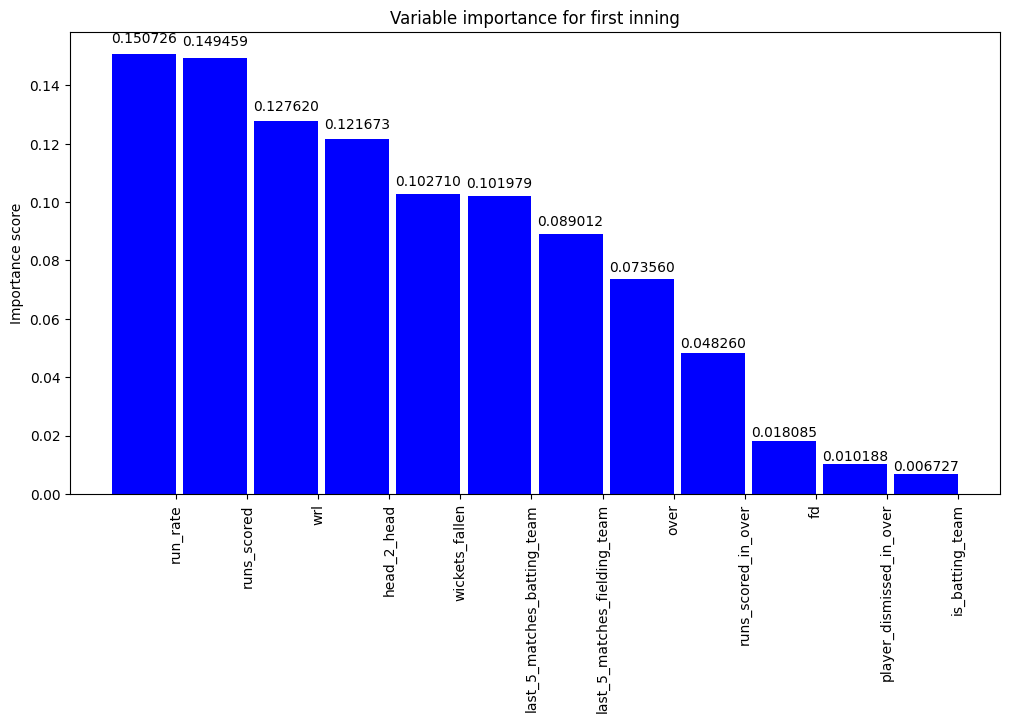

In [565]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()


create_feature_map(x_cols)
importance = model_1.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(),
                    key=operator.itemgetter(1), reverse=True)
imp_df = pd.DataFrame(importance, columns=['feature', 'fscore'])
imp_df['fscore'] = imp_df['fscore'] / imp_df['fscore'].sum()

# create a function for labeling #


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%f' % float(height),
                ha='center', va='bottom')


labels = np.array(imp_df.feature.values)
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12, 6))
rects = ax.bar(ind, np.array(imp_df.fscore.values), width=width, color='b')
ax.set_xticks(ind+((width)/2.))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_ylabel("Importance score")
ax.set_title("Variable importance for first inning")
autolabel(rects)
plt.show()

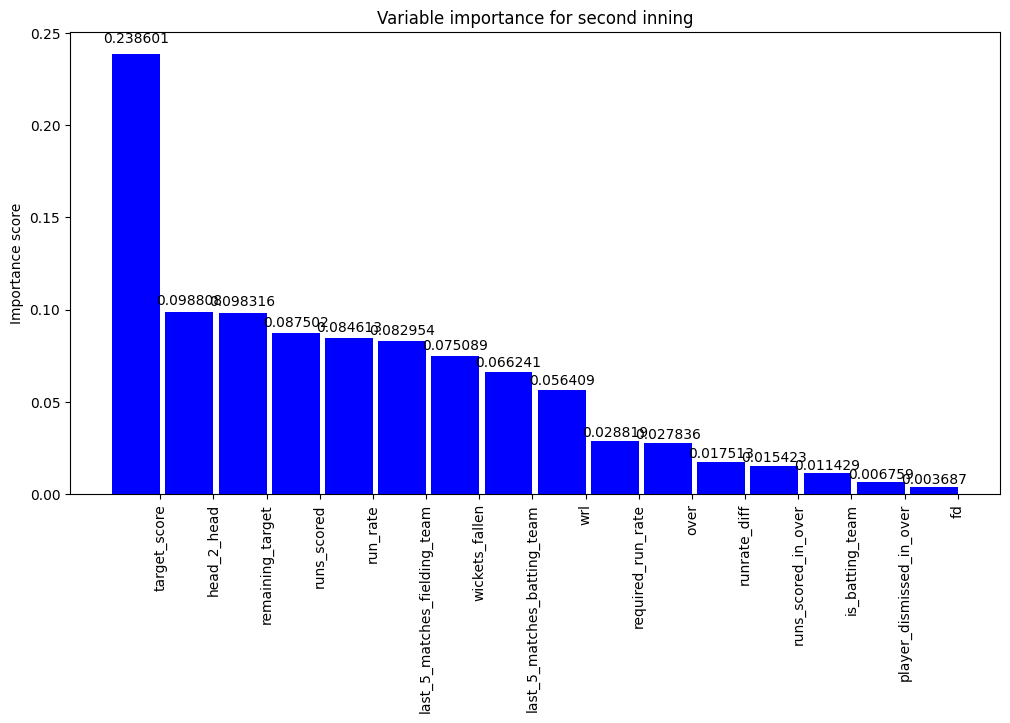

In [566]:
create_feature_map(x_cols)
importance = model_2.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(),
                    key=operator.itemgetter(1), reverse=True)
imp_df = pd.DataFrame(importance, columns=['feature', 'fscore'])
imp_df['fscore'] = imp_df['fscore'] / imp_df['fscore'].sum()

# create a function for labeling #


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%f' % float(height),
                ha='center', va='bottom')


labels = np.array(imp_df.feature.values)
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12, 6))
rects = ax.bar(ind, np.array(imp_df.fscore.values), width=width, color='b')
ax.set_xticks(ind+((width)/2.))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_ylabel("Importance score")
ax.set_title("Variable importance for second inning")
autolabel(rects)
plt.show()

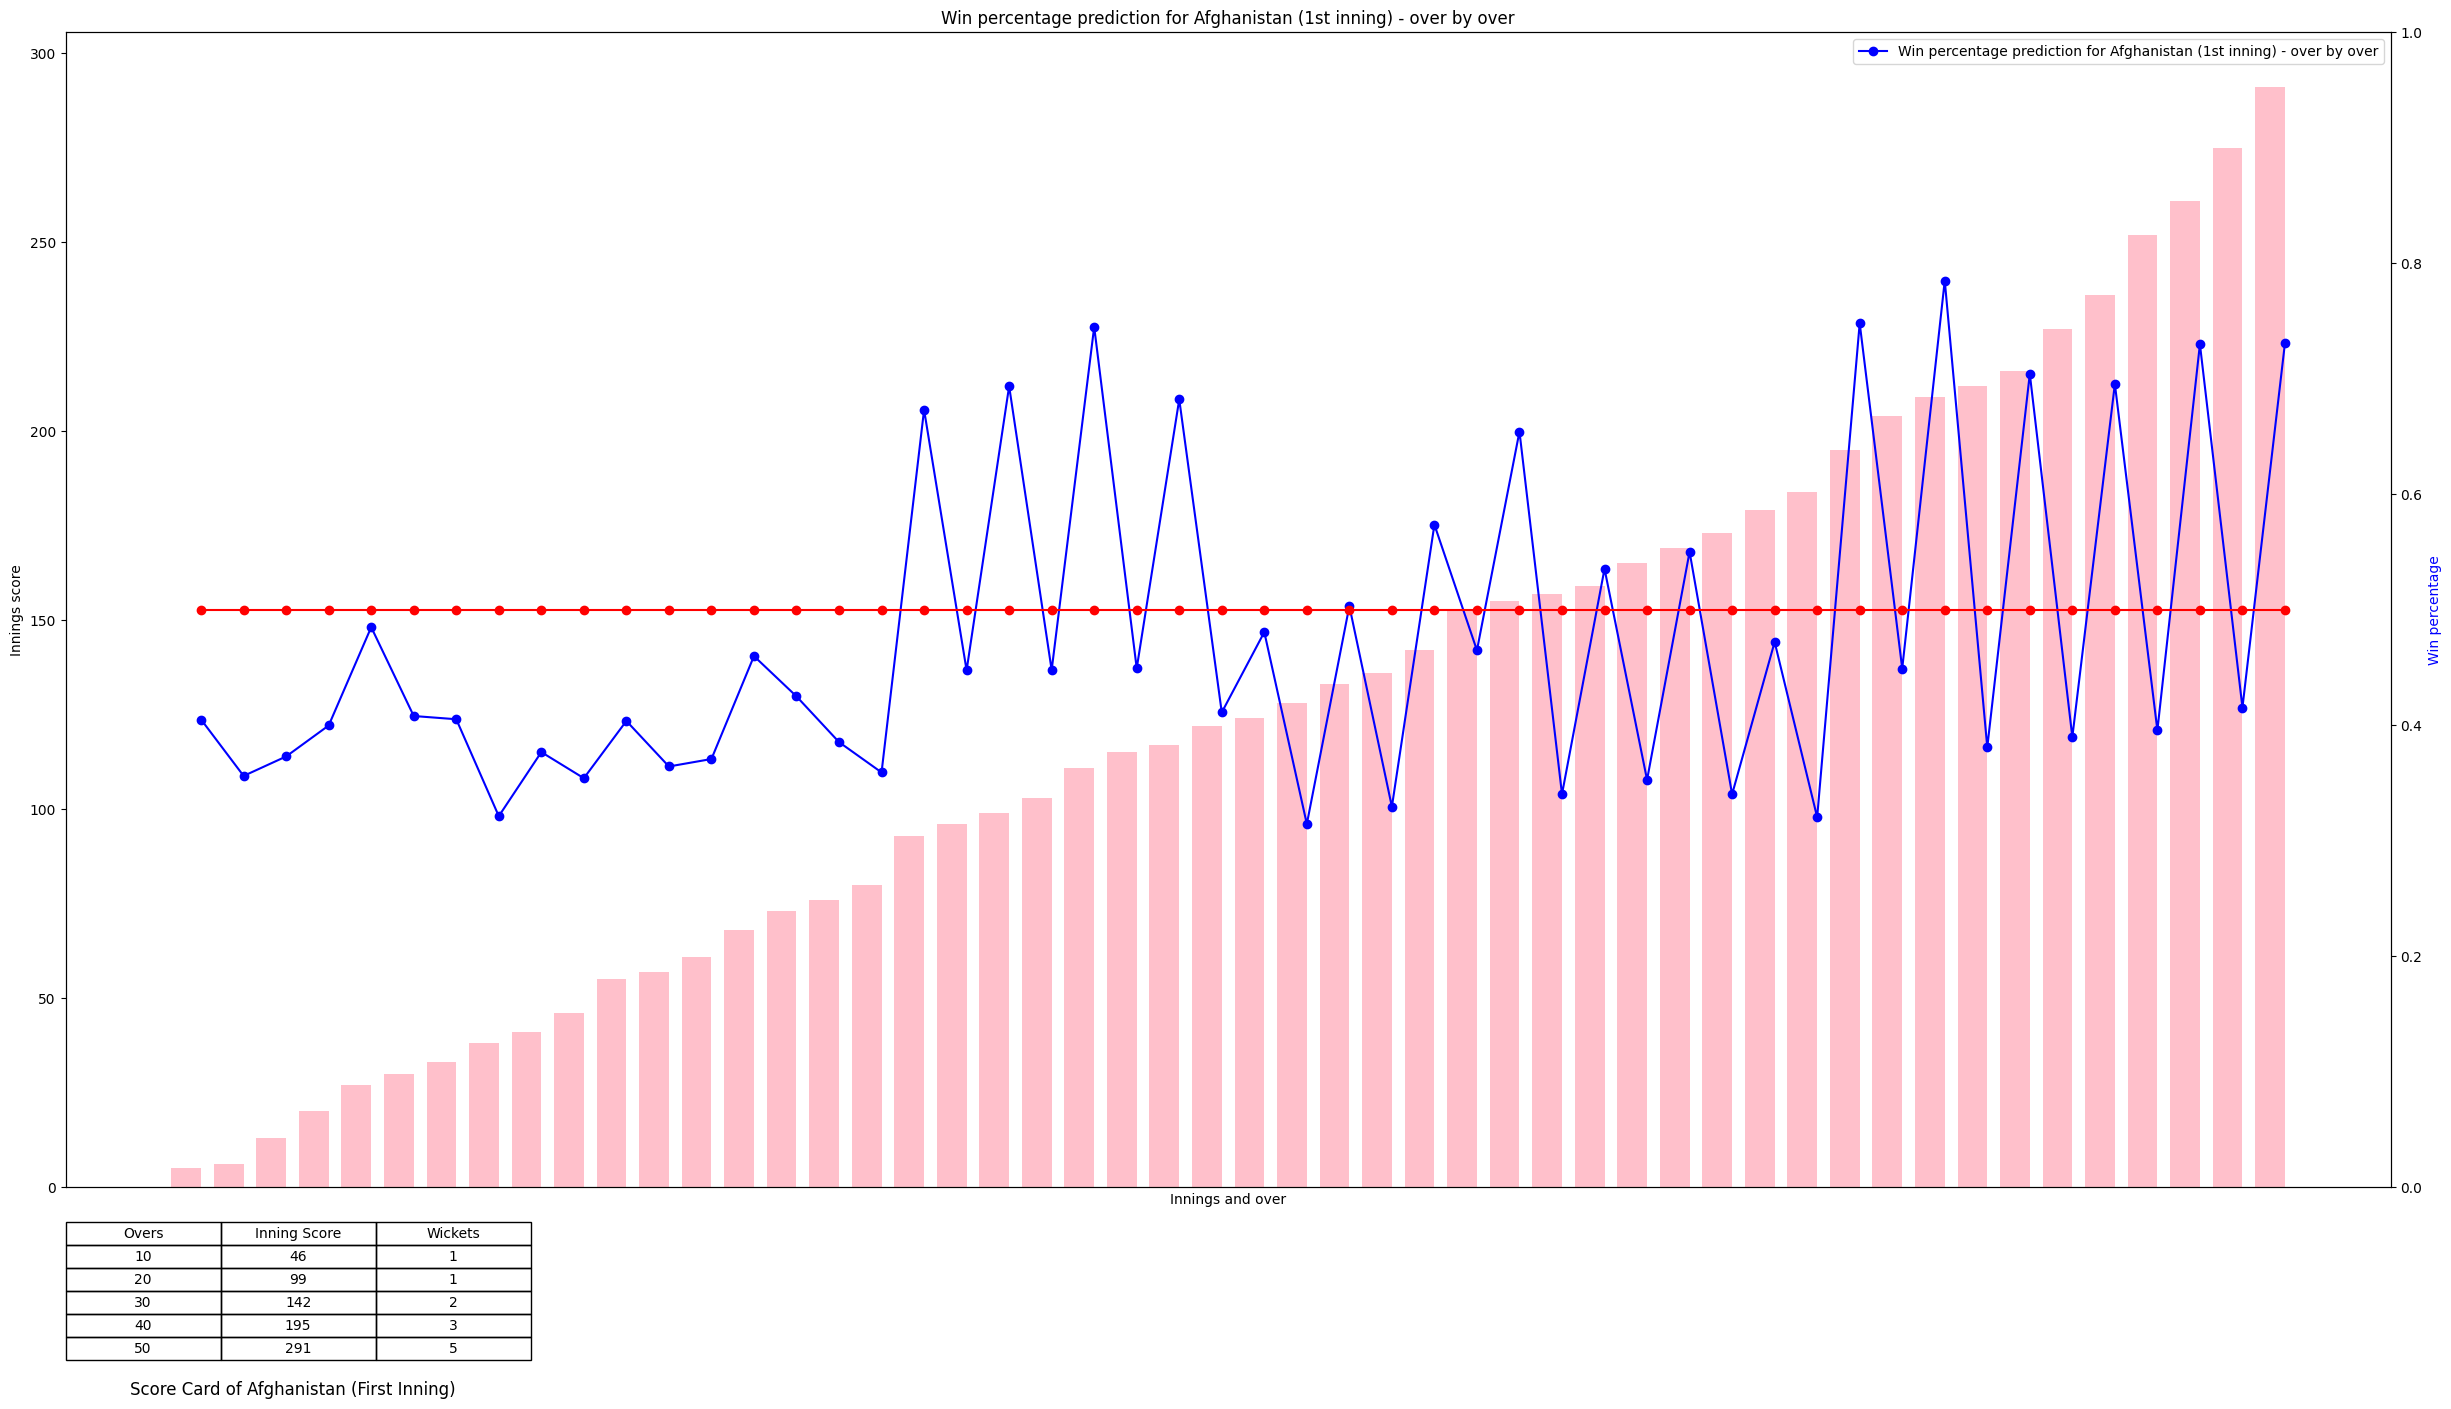

In [567]:
out_df_1 = pd.DataFrame({'Team1': val_df_1.team1.values})
out_df_1['is_batting_team'] = val_df_1.is_batting_team.values
out_df_1['innings_over'] = np.array(val_df_1.apply(
    lambda row:str(row['over']), axis=1))
out_df_1['runs_scored'] = val_df_1.runs_scored.values
out_df_1['wickets_fallen'] = val_df_1.wickets_fallen.values
out_df_1['target_score'] = val_df_1.target_score.values
out_df_1['runs_scored_in_over'] = val_df_1.runs_scored_in_over.values
out_df_1['wickets_in_over'] = val_df_1.player_dismissed_in_over.values
out_df_1['batting_team'] = val_df_1.batting_team.values
out_df_1['predictions'] = list(preds_1)

data_1 = [['Overs','Inning Score', 'Wickets']]
for i in range(9, 50, 10):
    data_1.append([out_df_1['innings_over'][i],
                  out_df_1['runs_scored'][i], out_df_1['wickets_fallen'][i]])


fig, ax1 = plt.subplots(figsize=(30, 15))
ax2 = ax1.twinx()
labels = np.array(out_df_1['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df_1['runs_scored']), width=width, color=['pink']*50 )
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Innings score")
ax1.set_xlabel("Innings and over")
title = "Win percentage prediction for " + out_df_1.batting_team[0] + " (1st inning) - over by over"
ax1.set_title(title)

cell_text = []
for row in data_1:
    cell_text.append(row)

table_title = "Score Card of " + out_df_1.batting_team[0] + " (First Inning)"
plt.table(cellText=cell_text,
          loc='bottom',
          cellLoc='center',
          cellColours=[['none']*len(data_1[0])] *
          len(data_1),  # No cell color for border
          # Adjust table position and size using bbox
          bbox=[0,-0.15, 0.2, 0.12]
          )

table_label = plt.text(2.5, -0.18, table_title, ha='center', fontsize=12)

# Remove x-axis ticks for better visualization
plt.xticks([])



ax2.plot(ind+0.35, np.array(out_df_1['predictions']), color='b', marker='o',label= title)
ax2.plot(ind+0.35, np.array([0.5]*50), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0, 1])
ax2.grid(False)
plt.legend()
plt.show()

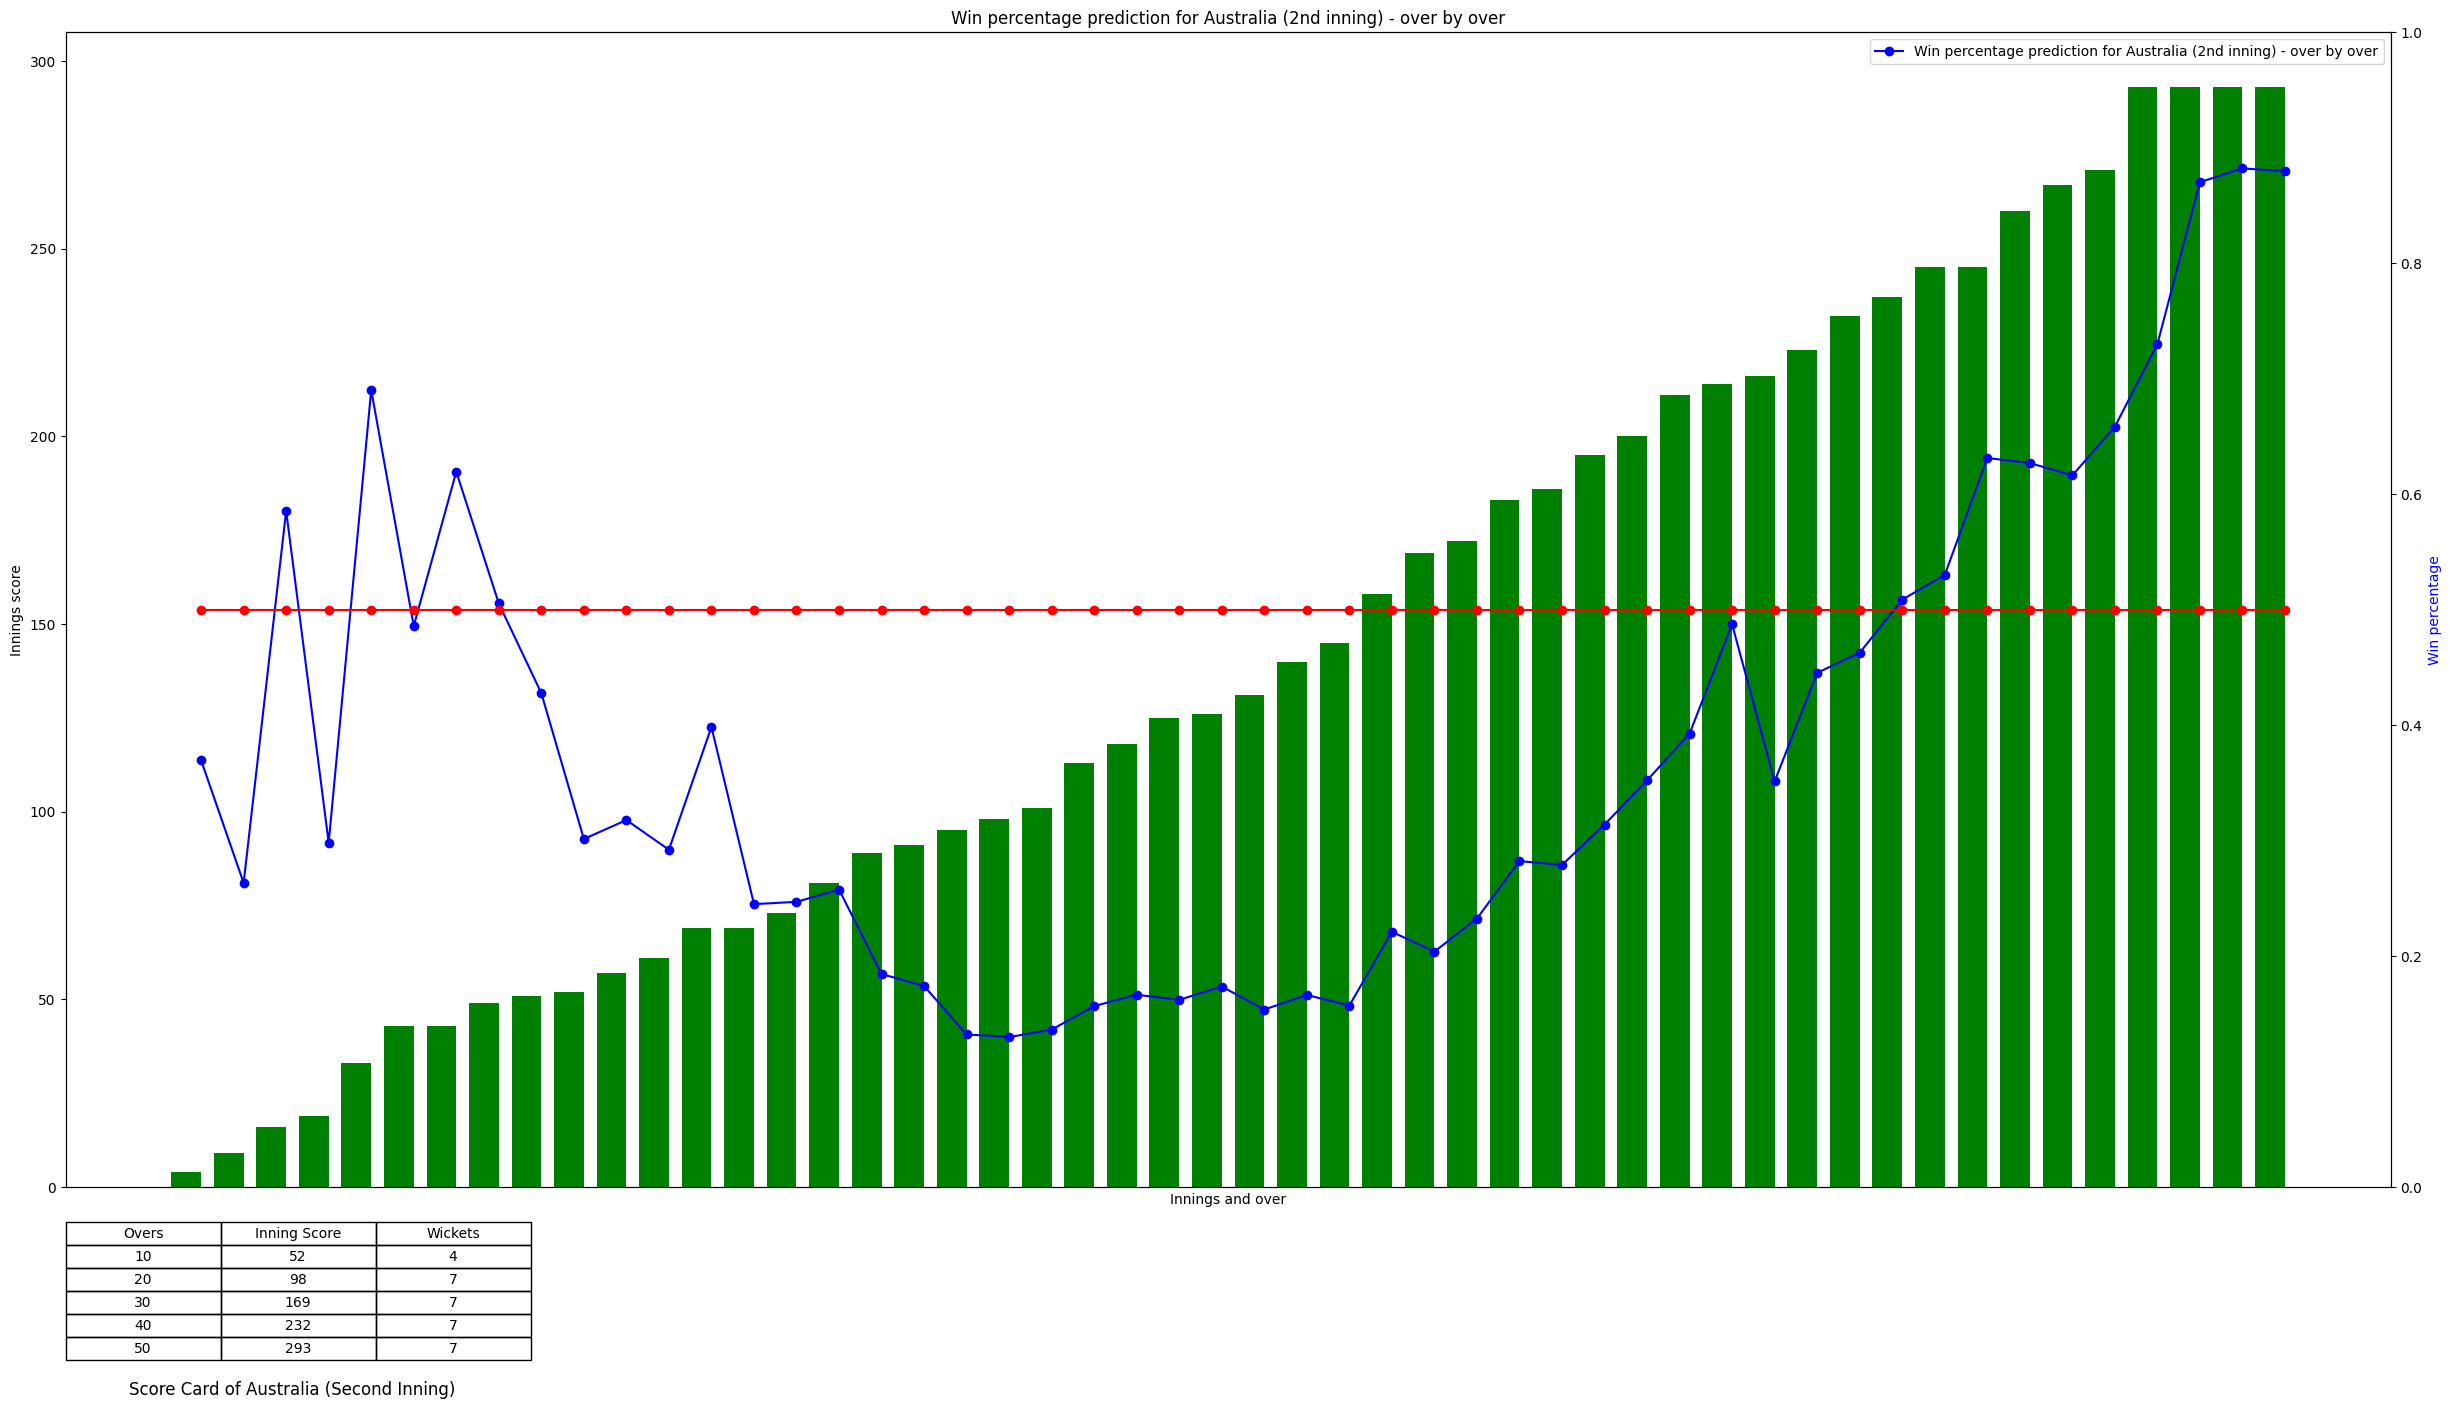

In [568]:
out_df_2 = pd.DataFrame({'Team1': val_df_2.team1.values})
out_df_2['is_batting_team'] = val_df_2.is_batting_team.values
out_df_2['innings_over'] = np.array(val_df_2.apply(
    lambda row: str(row['over']), axis=1))
out_df_2['runs_scored'] = val_df_2.runs_scored.values
out_df_2['wickets_fallen'] = val_df_2.wickets_fallen.values
out_df_2['target_score'] = val_df_2.target_score.values
out_df_2['runs_scored_in_over'] = val_df_2.runs_scored_in_over.values
out_df_2['wickets_in_over'] = val_df_2.player_dismissed_in_over.values
out_df_2['batting_team'] = val_df_2.batting_team.values
out_df_2['predictions'] = list(preds_2)

data_2 = [['Overs', 'Inning Score', 'Wickets']]
for i in range(9, 50, 10):
    data_2.append([out_df_2['innings_over'][i],
                  out_df_2['runs_scored'][i], out_df_2['wickets_fallen'][i]])


fig, ax1 = plt.subplots(figsize=(30, 15))
ax2 = ax1.twinx()
labels = np.array(out_df_2['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(
    out_df_2['runs_scored']), width=width, color=['green']*50)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Innings score")
ax1.set_xlabel("Innings and over")
title = "Win percentage prediction for " + out_df_2.batting_team[0] + " (2nd inning) - over by over"
ax1.set_title(title)

cell_text = []
for row in data_2:
    cell_text.append(row)

table_title = "Score Card of " + out_df_2.batting_team[0] + " (Second Inning)"
plt.table(cellText=cell_text,
          loc='bottom',
          cellLoc='center',
          cellColours=[['none']*len(data_2[0])] *
          len(data_2),  # No cell color for border
          # Adjust table position and size using bbox
          bbox=[0, -0.15, 0.2, 0.12]
          )

table_label = plt.text(2.5, -0.18, table_title, ha='center', fontsize=12)

# Remove x-axis ticks for better visualization
plt.xticks([])

ax2.plot(ind+0.35, 1-np.array(out_df_2['predictions']), color='b', marker='o',label = title)
ax2.plot(ind+0.35, np.array([0.5]*50), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0, 1])
ax2.grid(False)
plt.legend()
plt.show()

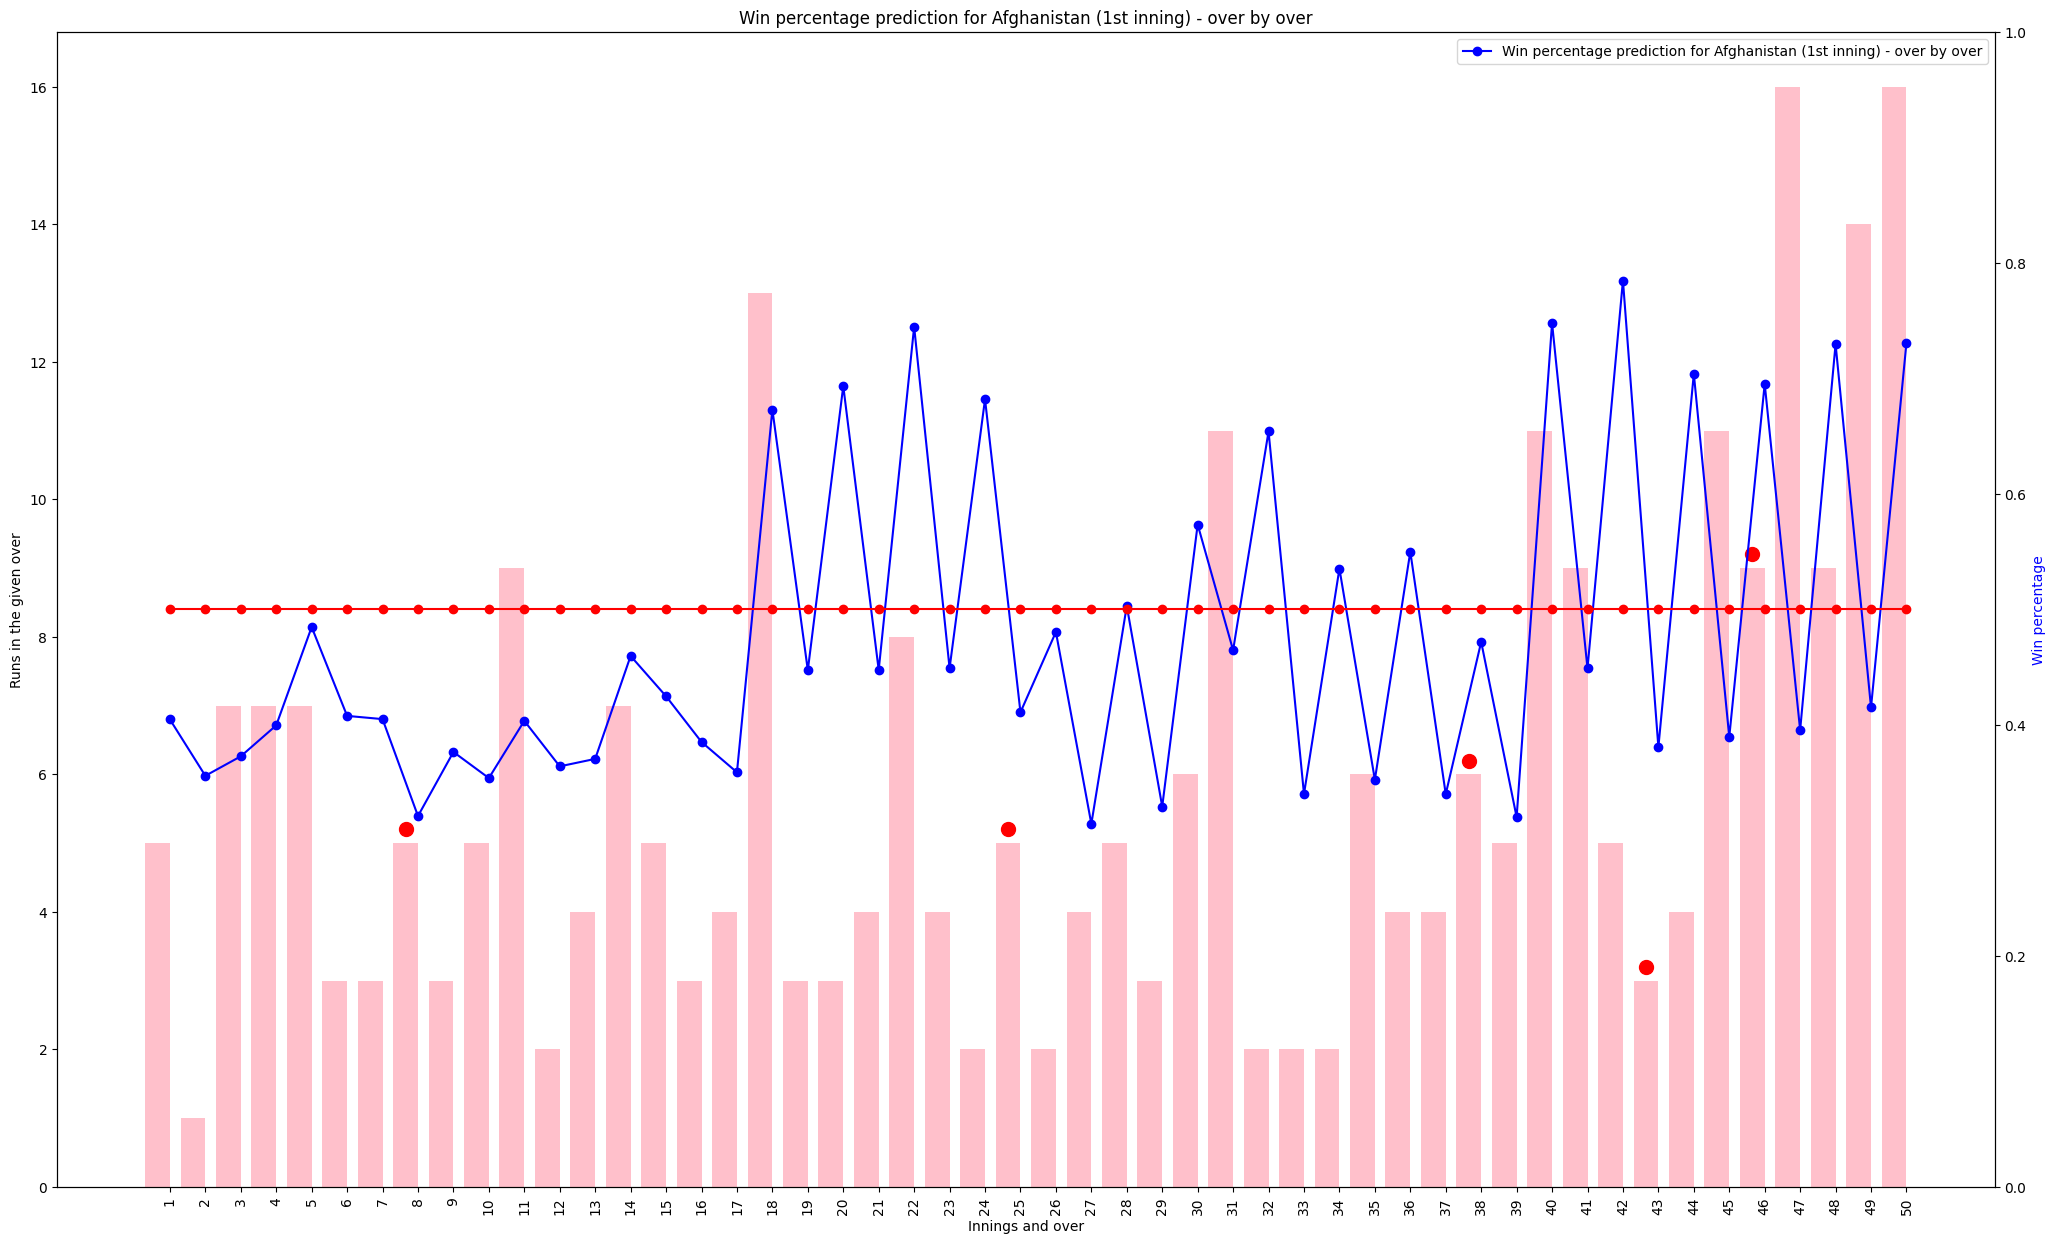

In [569]:

fig, ax1 = plt.subplots(figsize=(25, 15))
ax2 = ax1.twinx()
labels = np.array(out_df_1['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df_1['runs_scored_in_over']), width=width, color=[
                'pink']*50)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Runs in the given over")
ax1.set_xlabel("Innings and over")
title = "Win percentage prediction for " + out_df_1.batting_team[0] + " (1st inning) - over by over"
ax1.set_title(title)

runs = np.array(out_df_1['runs_scored_in_over'])
wickets = np.array(out_df_1['wickets_in_over'])
for i, wicket_count in enumerate(wickets):
    for _ in range(wicket_count):
        ax1.scatter(ind[i], runs[i] + 0.2 * (_ + 1),
                    color='red', marker='o', s=100)

ax2.plot(ind+0.35, np.array(out_df_1['predictions']), color='b', marker='o',label = title)
ax2.plot(ind+0.35, np.array([0.5]*50), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0, 1])
ax2.grid(False)
plt.legend()
plt.show()

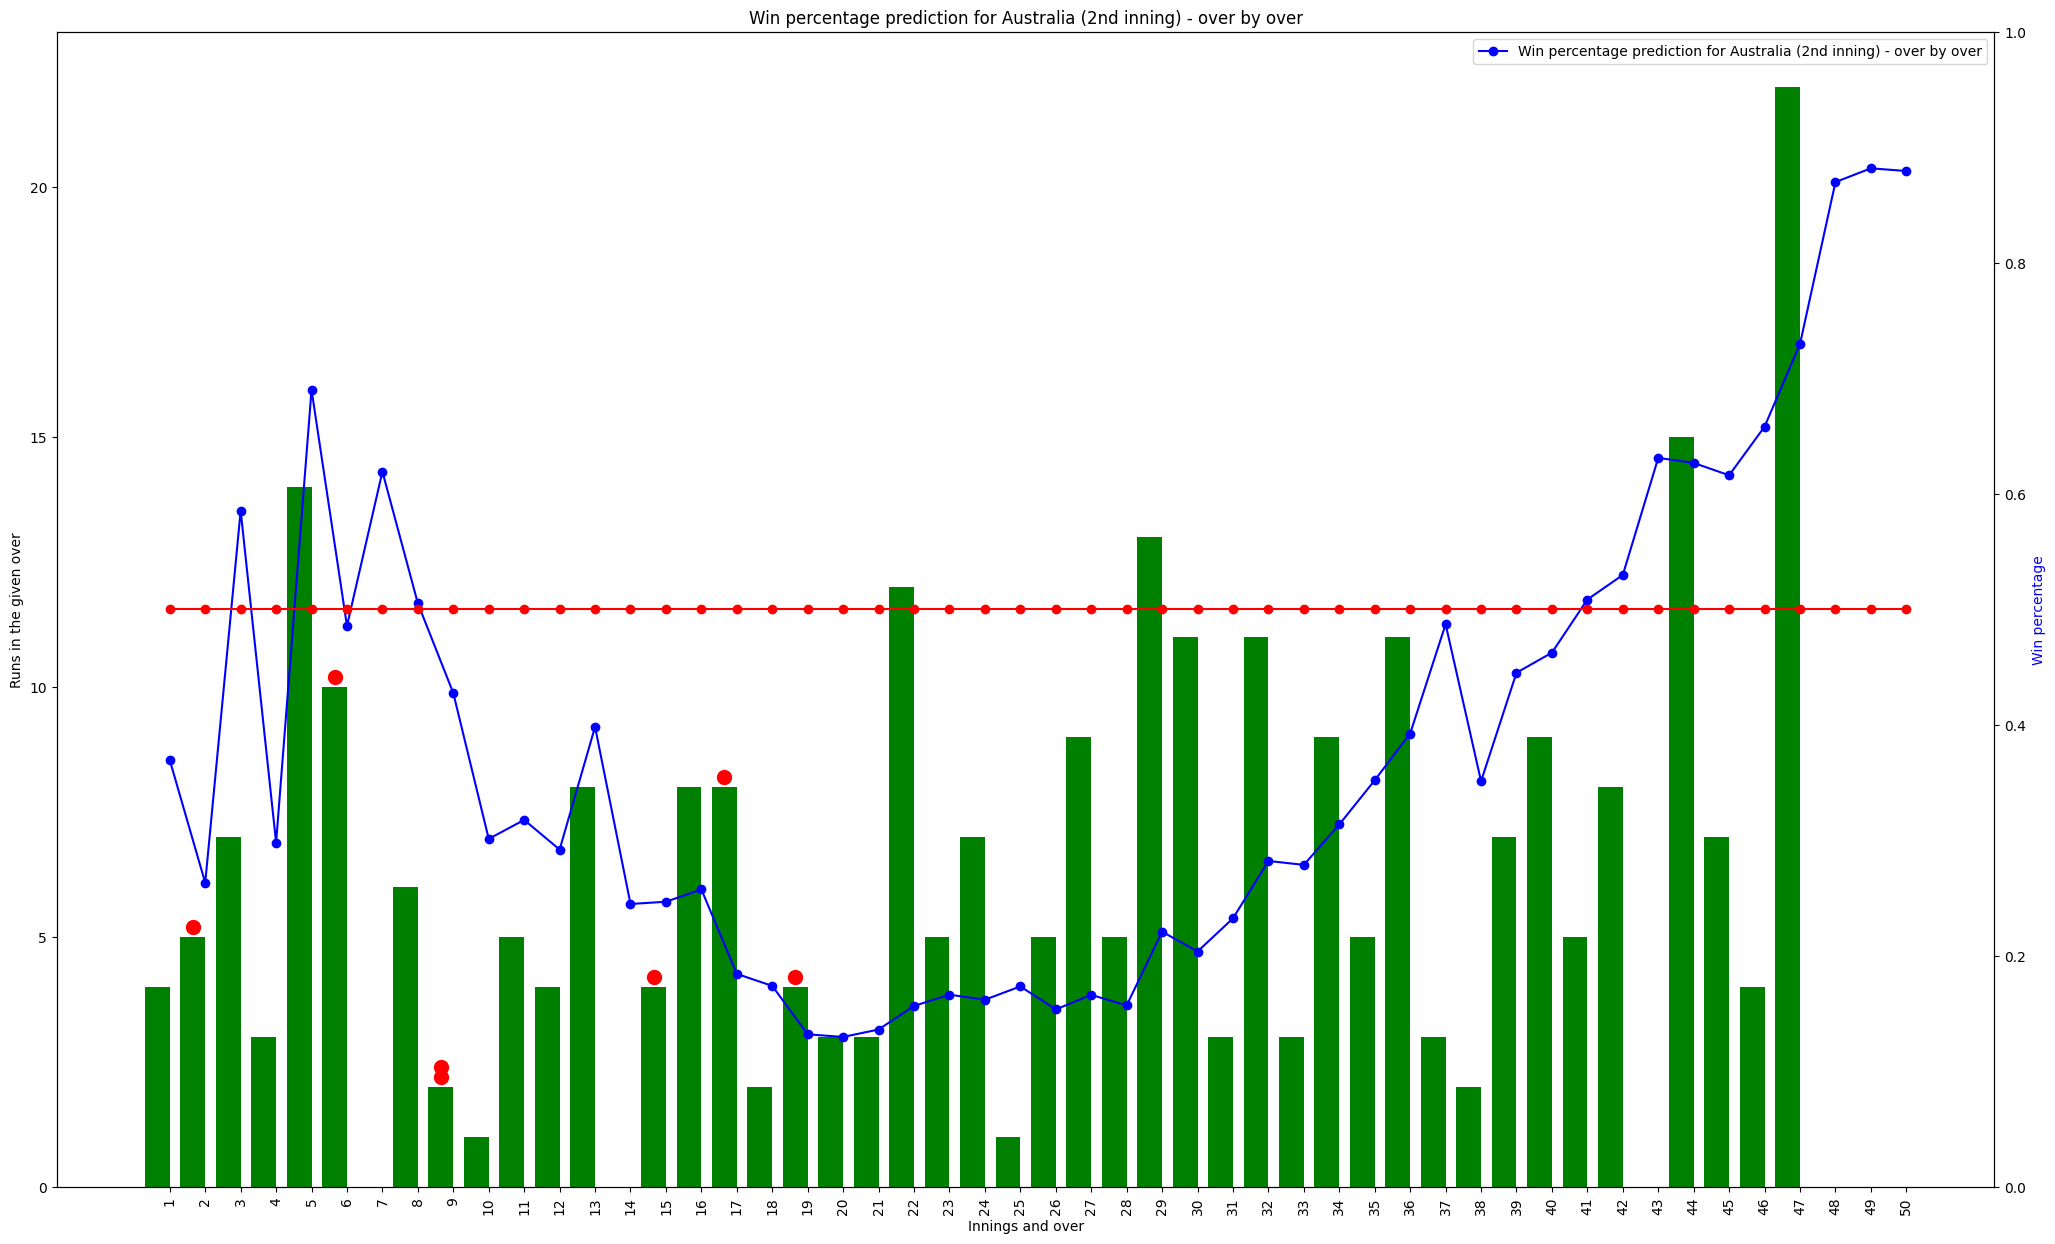

In [570]:
fig, ax1 = plt.subplots(figsize=(25, 15))
ax2 = ax1.twinx()
labels = np.array(out_df_2['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df_2['runs_scored_in_over']), width=width, color=['green']*50)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Runs in the given over")
ax1.set_xlabel("Innings and over")
title = "Win percentage prediction for " + out_df_2.batting_team[0] + " (2nd inning) - over by over"
ax1.set_title(title)

runs = np.array(out_df_2['runs_scored_in_over'])
wickets = np.array(out_df_2['wickets_in_over'])
for i, wicket_count in enumerate(wickets):
    for _ in range(wicket_count):
        ax1.scatter(ind[i], runs[i] + 0.2 * (_ + 1),
                    color='red', marker='o', s=100)

ax2.plot(ind+0.35, 1-np.array(out_df_2['predictions']), color='b', marker='o',label = title)
ax2.plot(ind+0.35, np.array([0.5]*50), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0, 1])
ax2.grid(False)
plt.legend()
plt.show()

117900